In [9]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_lowercase
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit_algorithms import AmplificationProblem, Grover
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from utils import get_image_path
from dotenv import load_dotenv
from qiskit_ibm_provider import IBMProvider

In [3]:
def random_file_name(size=5):
    return ''.join(random.sample(list(ascii_lowercase), size))

In [4]:
def create_test_folder(folder):
    if(not os.path.exists(folder)):
        print("Path doesnt exists")
        print(f"Creating: {folder}")
        os.mkdir(folder)
    print("Path already exists!!")
    
def create_test_files(folder, n=5):
    create_test_folder(folder)
    for _ in range(n):
        file = random_file_name()+".txt"
        
        try:
            print(f"creating file: {file}")
            file_path = os.path.join(folder, file)

            file = open(file_path, "a")
            file.close()
        
        except Exception as error:
            print(f"Failed creating {file}")

test_folder = os.path.join('.', 'files-test')
create_test_files(test_folder)

Path already exists!!
creating file: falxe.txt
creating file: laznx.txt
creating file: ewlun.txt
creating file: rbmiu.txt
creating file: eonys.txt


In [5]:
files = os.listdir(test_folder)
files

['xlupn.txt',
 'zyedl.txt',
 'vqzbd.txt',
 'fovrj.txt',
 'agbhl.txt',
 'hoafv.txt',
 'myjkq.txt',
 'wyrhg.txt',
 'xcgav.txt',
 'lwzfy.txt',
 'vsxcj.txt',
 'xrapy.txt',
 'xashv.txt',
 'rfnkd.txt',
 'movze.txt',
 'falxe.txt',
 'laznx.txt',
 'ewlun.txt',
 'rbmiu.txt',
 'eonys.txt']

In [6]:
def classical_method_1(files, target):
    #in this example, we are ignoring the extension
    #just for this case, in real life a good idea is to use the entire name, or a hash of it

    #unsing no type of lookup table, or sorting, the algorithm takes O(n)
    total_tests = 0
    for file in files:
        total_tests += 1
        print(f"total tests: {total_tests}")
        if(file.replace('.txt', '') == target):
            print("found file")
            break

classical_method_1(files, "vqzbd")

total tests: 1
total tests: 2
total tests: 3
found file


In [7]:
def classical_method_2(files, target):

    # this should be done after adding a file into the filesystem
    # it takes O(1) for adding a new file, O(n) for adding n files and O(1) for searching
    lut = {}
    for file in files:
        file_hash = hash(file.replace('.txt', ''))
        lut[file_hash] = file

    target_hash = hash(target)
    if lut.get(target_hash):
        print("File found")
    else:
        print("File doesnt exists in the filesystem")
        
classical_method_2(files, 'vqzbd')

File found


---

In [8]:
n_qubits = int(np.ceil(np.log2(len(files))))

/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


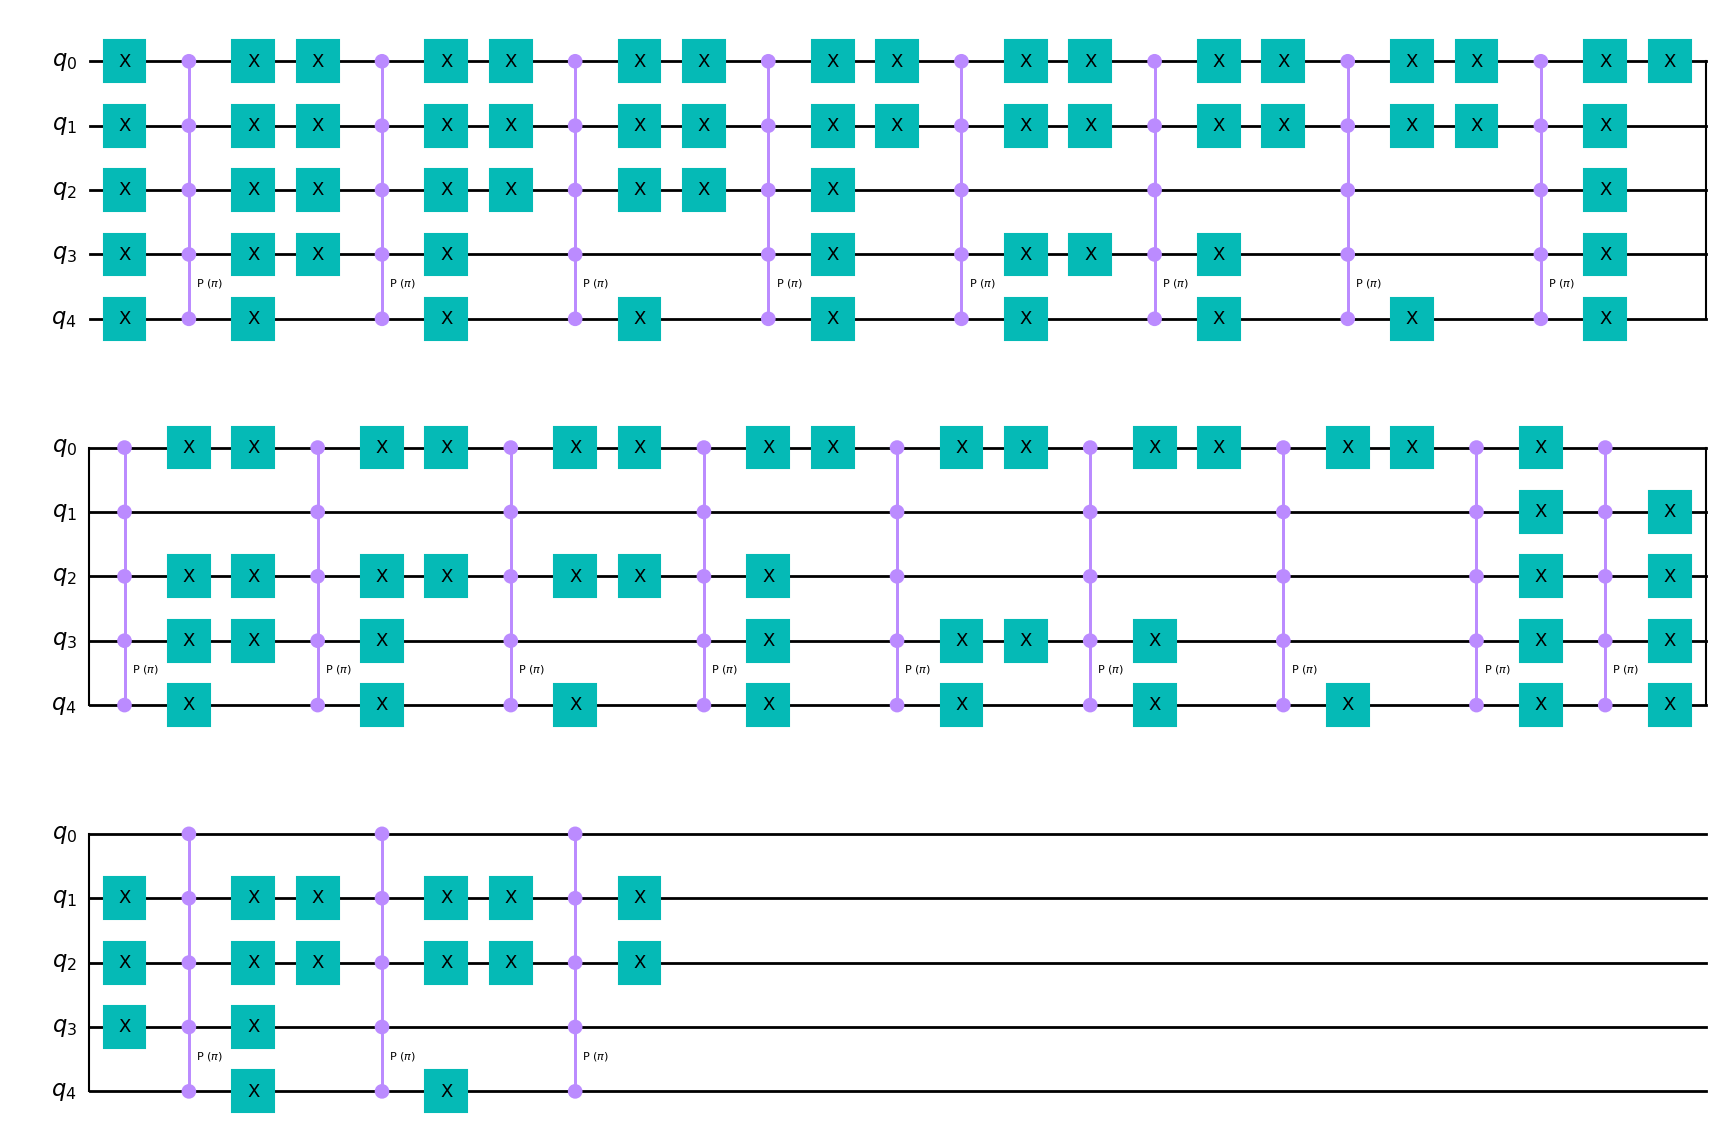

In [9]:
def encoding_files_to_oracle(n_qubits, files):
    oracle = QuantumCircuit(n_qubits, name="LUT")

    encoded_bin = [bin(i)[2:].zfill(n_qubits) for i in range(len(files))]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

binary,oracle = encoding_files_to_oracle(n_qubits,files)
oracle.draw('mpl', filename=get_image_path("look-up-table.png"))

In [10]:
def get_oracle_overload(files, targets):
    oracle = QuantumCircuit(n_qubits, name="$LUT^{-1}$")

    encode = lambda x,n: bin(x)[2:].zfill(n)
    encoded_bin = [encode(i,n_qubits) for i, file in enumerate(files) if file not in targets]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

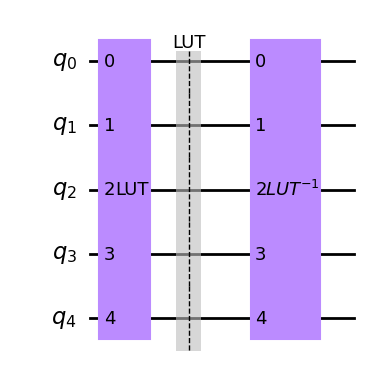

In [11]:
lut_binary,oracle = encoding_files_to_oracle(n_qubits,files)
unvalid_states,oracle_inv = get_oracle_overload(files, ['vqzbd.txt'])

good_state = list(set(lut_binary) - set(unvalid_states))

n_qubits = len(oracle.qubits)

qc = QuantumCircuit(n_qubits)
qc.append(oracle, range(n_qubits))
qc.barrier(label="LUT")
qc.append(oracle_inv, range(n_qubits))
qc.draw('mpl', filename=get_image_path("sets-difference-look-up-table-oracle.png"))

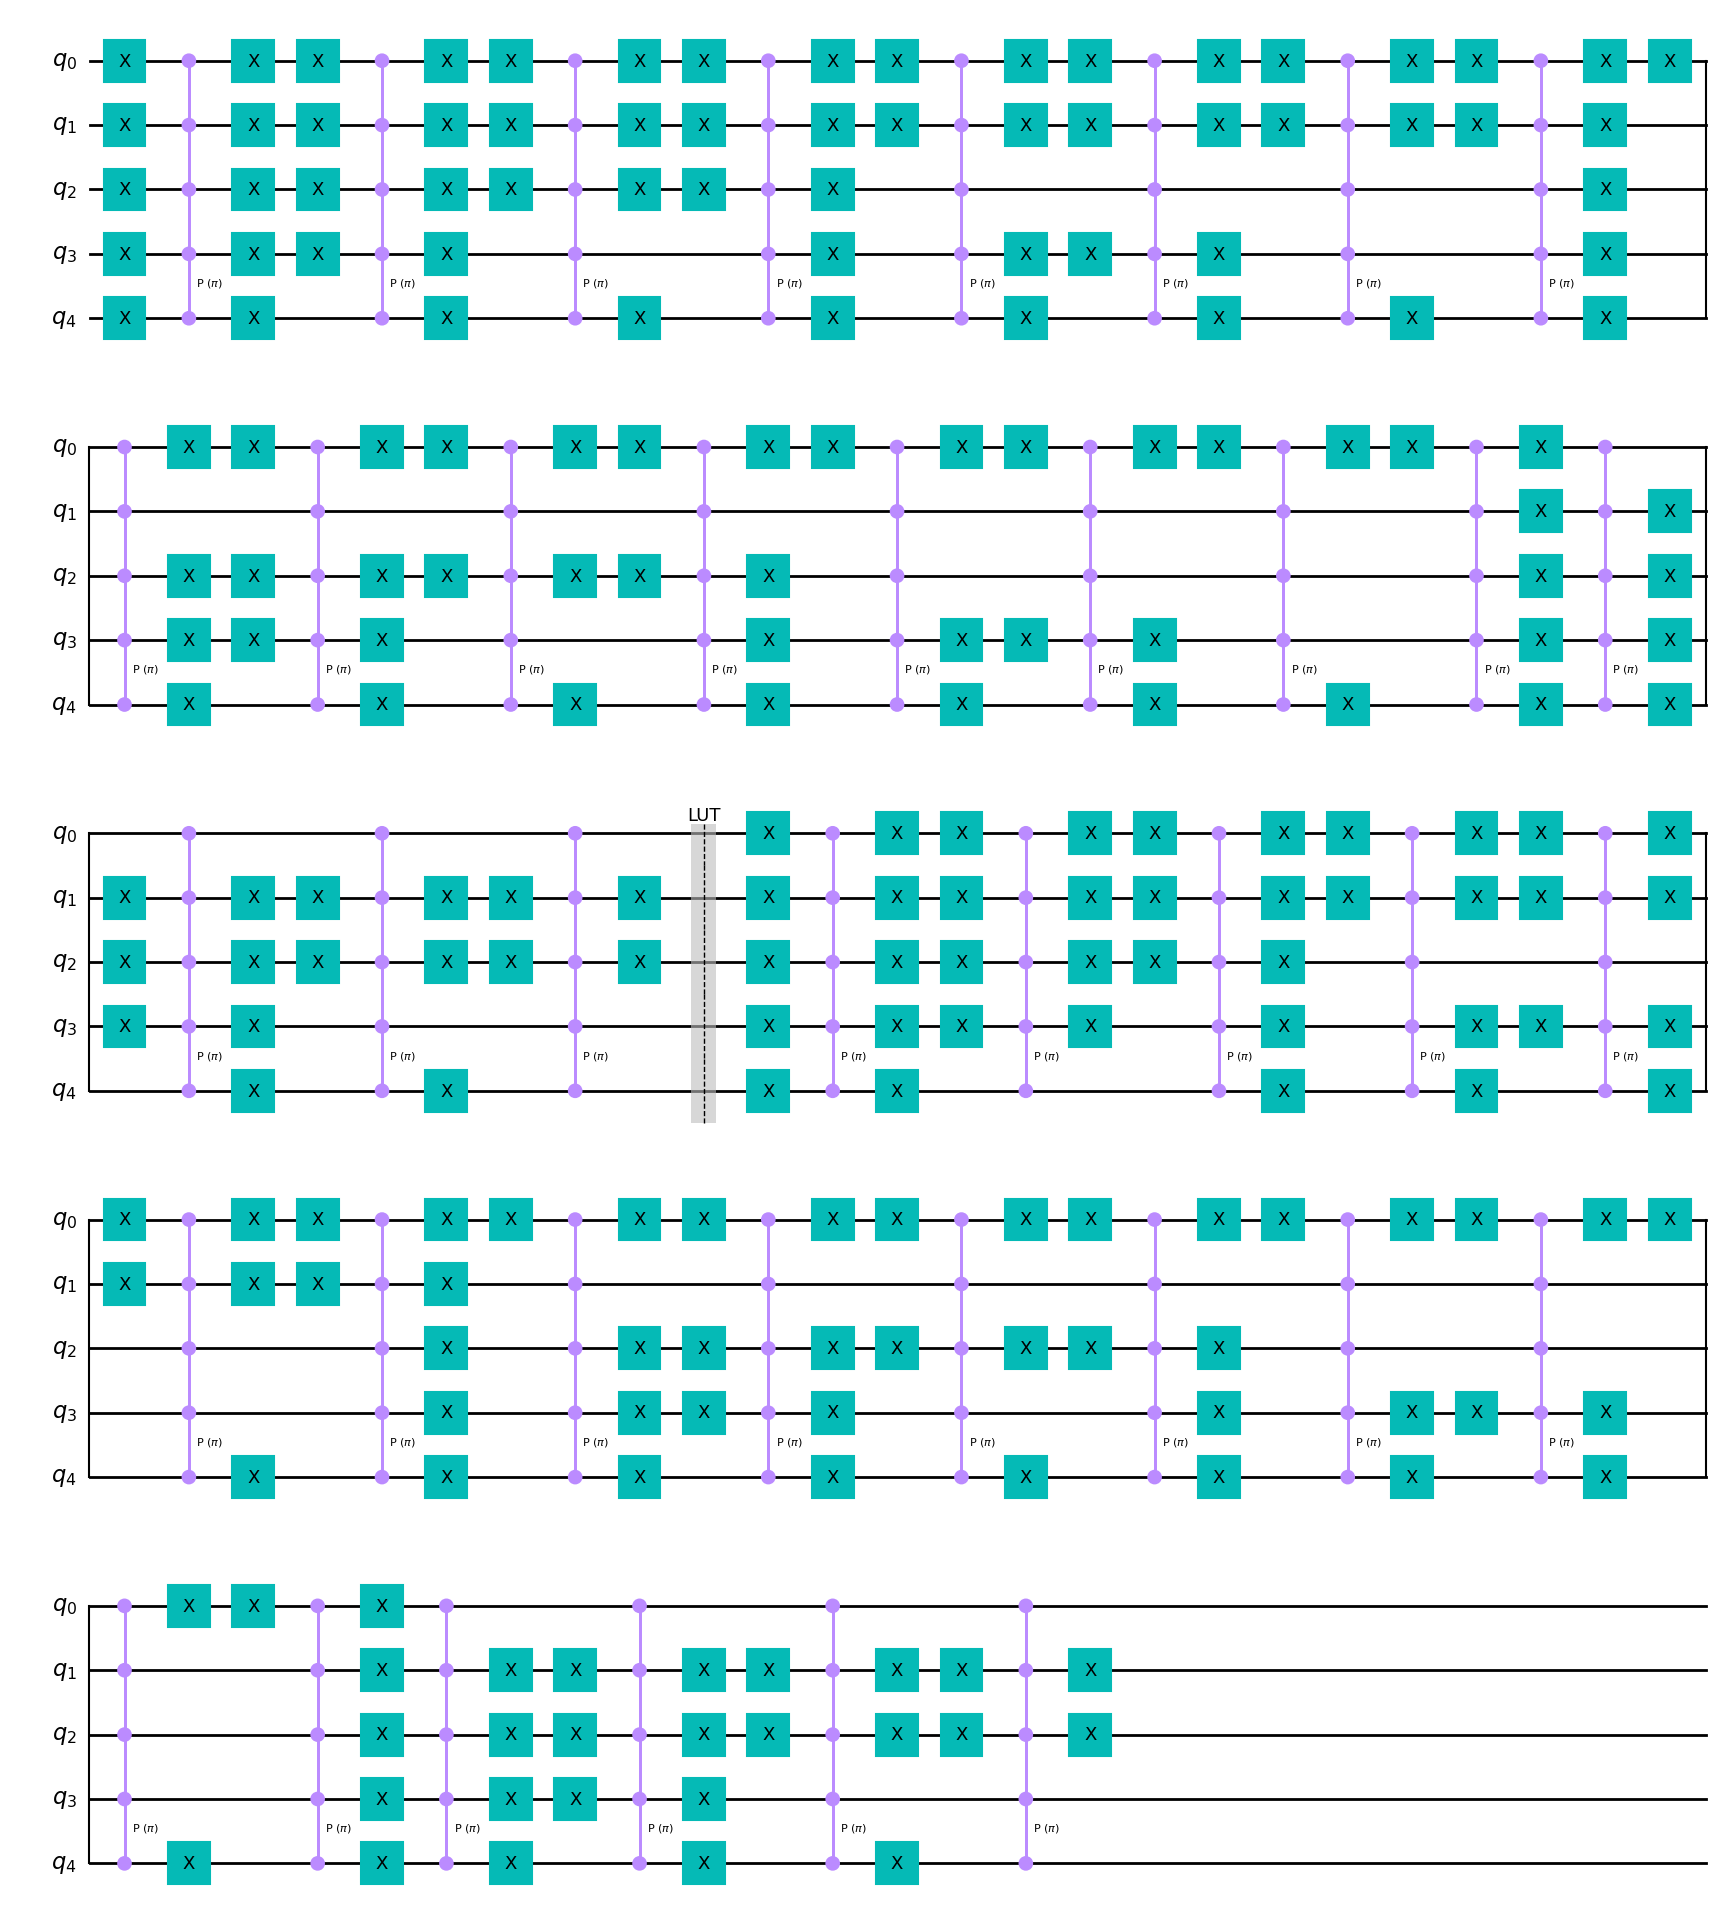

In [12]:
qc.decompose().draw('mpl')

In [13]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

In [14]:
qc_copy = qc.copy()
qc_copy.save_unitary()

sim = AerSimulator()
unitary = sim.run(transpile(qc_copy, sim)).result().get_unitary()
array_to_latex(unitary, max_size=10000)

<IPython.core.display.Latex object>

/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


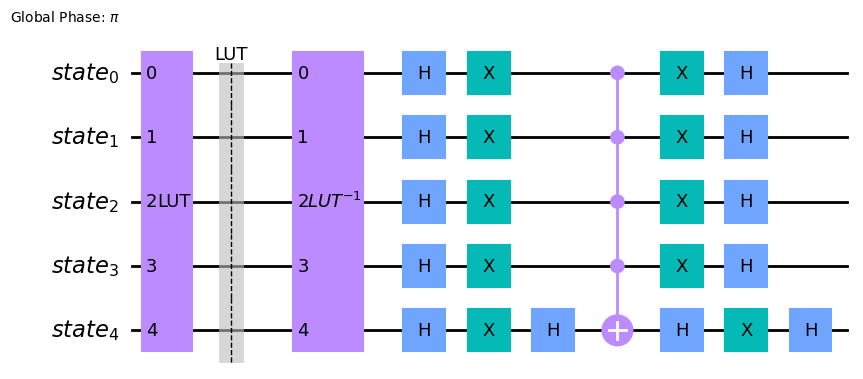

In [15]:
problem = AmplificationProblem(qc, is_good_state=good_state)
problem.grover_operator.decompose().draw(output='mpl', filename=get_image_path("lut-grover.png"))

In [16]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
result.top_measurement

'01000'

---

In [17]:
load_dotenv()
IBMProvider.save_account(token=os.getenv("IBM_TOKEN"), overwrite=True)

In [18]:
provider = IBMProvider()

In [19]:
backends = provider.backends(min_num_qubits=4, operational=True, simulator=False)

min_pending_jobs = 100000
less_busier_backend = None

for backend in backends:
    pending_jobs = backend.status().pending_jobs
    backend_name = backend.name
    
    if(pending_jobs < min_pending_jobs):
        less_busier_backend = backend_name
        min_pending_jobs = pending_jobs
        
    print(f"{backend_name}: {pending_jobs}")

ibm_kyoto: 7
ibm_osaka: 2
ibm_brisbane: 27


In [20]:
backend = provider.get_backend(less_busier_backend)

In [21]:
qc = problem.grover_operator.decompose()

In [29]:
with backend.open_session() as session:
    transpiled_qc = transpile(qc.decompose(), backend)
    job = backend.run(transpiled_qc, shots=1000)
    result = job.result()
    print(job.job_id())
    print(result)
    plot_histogram(result.get_counts())

KeyError: 16

In [38]:
x = np.array(list(range(0, 30)), dtype=np.int64)

classical_find = lambda x: x
classical_lut = lambda x: 1
quantum = lambda x: np.sqrt(x)

vec_cf = np.vectorize(classical_find)
vec_cl = np.vectorize(classical_lut)
vec_q = np.vectorize(quantum)

y_classical_f = vec_cf(x)
y_classical_l = vec_cl(x)
y_quantum = vec_q(x)

In [39]:
df = pd.DataFrame({"x":x, "cf":y_classical_f, "cl":y_classical_l, "q":y_quantum})
df.head()

,x,cf,cl,q
0,0,0,1,0.000000
1,1,1,1,1.000000
2,2,2,1,1.414214
3,3,3,1,1.732051
4,4,4,1,2.000000


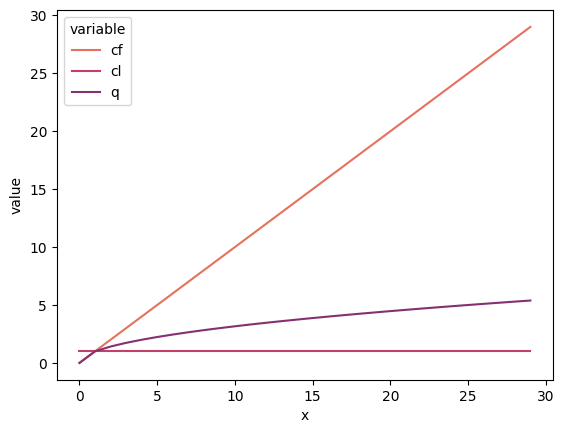

In [41]:
sns.lineplot(data=pd.melt(df, ["x"]), x="x", y="value", hue="variable", palette="flare")
plt.savefig(get_image_path("algorithms-finding-comparation.png"))
plt.show()